<a href="https://colab.research.google.com/github/RuksatKhanShayoni/DeepLearning-CS898AB-/blob/Assignment4-Ques1-RNN_EnglishtoFrench/Assignment_4_Ques1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The code is borrowed from the following link
- [Original Code](https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb)

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [ ]:
import collections
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Dataset
The dataset is located at **data** folder. The \"small_vocab_en\" contains English senteces and the "small_vocab_fr" contains the corresponding French translation.

In [2]:
import os
def load_data(path):
    data_file = os.path.join(path)
    with open(data_file,"r") as f:
        lang_data = f.read()
    return lang_data.split('\n')


In [3]:
# Load English data
english_sentences = load_data('small_vocab_en.txt')
# Load French data
french_sentences = load_data('small_vocab_fr.txt')
print('Dataset Loaded')

Dataset Loaded


### Visualize data
Each line in small_vocab_en contains an English sentence with the respective translation in each line of small_vocab_fr. View the first two lines from each file.

In [4]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [5]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:

Tokenize the words into ids
Add padding to make all the sequences the same length.
Time to start preprocessing the data...

#### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number. These are called character and word ids, respectively. Character ids are used for character level models that generate text predictions for each character. A word level model uses word ids that generate text predictions for each word. Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's Tokenizer function. Use this function to tokenize english_sentences and french_sentences in the cell below.

Running the cell will run tokenize on sample data and show output for debugging.

In [6]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)  
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [7]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline. Instead, we've provided you with the implementation of the preprocess function.

In [12]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)+1

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [9]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [10]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy,
                 optimizer = Adam(learning_rate),
                 metrics = ['accuracy'])

    return model


#tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

(21, 1)


In [11]:
# Train the neural network
simple_rnn_model = simple_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

simple_rnn_model.summary()

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 21, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 21, 345)        │        22,425 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,289 (137.85 KB)

 Trainable params: 35,289 (137.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.5729 - loss: 1.8569 - val_accuracy: 0.6523 - val_loss: 1.1895
Epoch 2/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.6579 - loss: 1.1565 - val_accuracy: 0.6599 - val_loss: 1.0814
Epoch 3/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.6731 - loss: 1.0655 - val_accuracy: 0.6895 - val_loss: 1.0293
Epoch 4/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.6880 - loss: 1.0168 - val_accuracy: 0.7076 - val_loss: 0.9773
Epoch 5/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.7040 - loss: 0.9687 - val_accuracy: 0.7188 - val_loss: 0.9358
Epoch 6/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.7201 - loss: 0.9229 - val_accuracy: 0.7248 - val_loss: 0.9011
Epoch 7/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.7274 - loss: 0.8944 - val_accuracy: 0.7345 - val_loss: 0.8797
Epoch 8/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.7323 - loss: 0

In [ ]:
prediction = simple_rnn_model.predict(tmp_x[:1])
print(logits_to_text(prediction[0], french_tokenizer))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
new jersey est parfois calme en l' et il est il est en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


## **2-layer RNN: Model Definition**

In [ ]:
from keras.models import Model
from keras.layers import Input, GRU, SimpleRNN, Dense, TimeDistributed, Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

#Build and return a 2-layer stacked Simple RNN model for sequence-to-sequence translation.
def stacked_rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    learning_rate = 1e-3

    # Input layer
    input_seq = Input(shape=input_shape[1:])

    # Stacked Simple RNN layers
    rnn_1 = SimpleRNN(128, return_sequences=True)(input_seq)
    rnn_2 = SimpleRNN(128, return_sequences=True)(rnn_1)

    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(rnn_2)
    output = Activation('softmax')(logits)

    # Model
    model = Model(inputs=input_seq, outputs=output)

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

(21, 1)


# **2-layer RNN: Training**

In [ ]:
# Train the neural network
stacked_rnn = stacked_rnn_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

# Display the model architecture
stacked_rnn.summary()

# Train the model
rnn_history = stacked_rnn.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 21, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 21, 128)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 21, 128)             │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 21, 345)             │          44,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 21, 345)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,041 (367.35 KB)

 Trainable params: 94,041 (367.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.6161 - loss: 1.4773 - val_accuracy: 0.7076 - val_loss: 0.9508
Epoch 2/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.7131 - loss: 0.9170 - val_accuracy: 0.7332 - val_loss: 0.8277
Epoch 3/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.7407 - loss: 0.7998 - val_accuracy: 0.7547 - val_loss: 0.7484
Epoch 4/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.7580 - loss: 0.7374 - val_accuracy: 0.7760 - val_loss: 0.6863
Epoch 5/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.7652 - loss: 0.7086 - val_accuracy: 0.7828 - val_loss: 0.6610
Epoch 6/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.7774 - loss: 0.6715 - val_accuracy: 0.7847 - val_loss: 0.6488
Epoch 7/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7813 - loss: 0.6567 - val_accuracy: 0.7819 - val_loss: 0.6483
Epoch 8/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7875 - loss: 0

# **Stacked 2-layer RNN: English to French Translation**

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences as pad

# reverse tokenizer for English and French
reverse_french_tokenizer = {index: word for word, index in french_tokenizer.word_index.items()}
reverse_french_tokenizer[0] = '<PAD>'

reverse_english_tokenizer = {index: word for word, index in english_tokenizer.word_index.items()}
reverse_english_tokenizer[0] = '<PAD>'

# 10 english input
sample_inputs = preproc_english_sentences[:10]

# Pad and reshape inputs, same as training
sample_inputs = pad(sample_inputs, max_french_sequence_length)
sample_inputs = sample_inputs.reshape((-1, max_french_sequence_length, 1))

# predict French translations using the stacked 2-layer RNN model
predictions = stacked_rnn.predict(sample_inputs)
predicted_token_ids = predictions.argmax(axis=-1)

# helper function to decode token sequences into readable sentences
def decode_tokens(token_ids, tokenizer_dict):
    return ' '.join([tokenizer_dict.get(token, '') for token in token_ids if token != 0])

# predict 10 english to french translations
for i in range(10):
    original_eng_tokens = preproc_english_sentences[i]
    english_sentence = decode_tokens(original_eng_tokens, reverse_english_tokenizer)
    french_sentence = decode_tokens(predicted_token_ids[i], reverse_french_tokenizer)

    print(f"English {i+1}: {english_sentence}")
    print(f"French {i+1}: {french_sentence}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
English 1: new jersey is sometimes quiet during autumn and it is snowy in april
French 1: bien new raisin new new new new unis est parfois chaud en mois et il est et il en

English 2: the united states is usually chilly during july and it is usually freezing in november
French 2: bien new raisin new new new new new unis est jamais doux en juillet et il est généralement beau en novembre

English 3: california is usually quiet during march and it is usually hot in june
French 3: bien new raisin new new new new est généralement habituellement en mars et il est généralement calme en juin

English 4: the united states is sometimes mild during june and it is cold in september
French 4: bien new raisin new new new new new unis est parfois humide en juin et il est froid en septembre

English 5: your least liked fruit is the grape but my least liked is the apple
French 5: bien new raisin new new new new jersey unis le aimé le la banane mais moins aimé est 

2-layer RNN: Graph

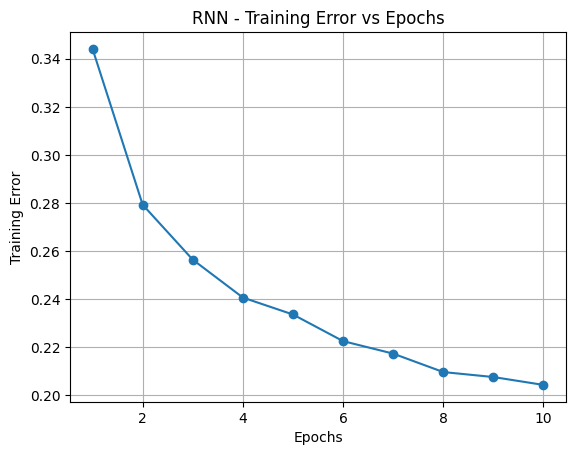

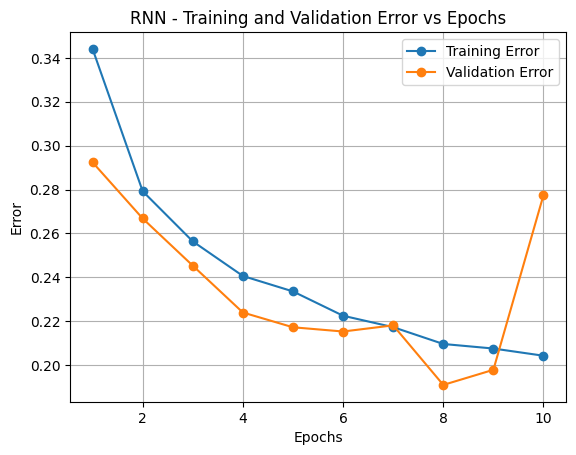

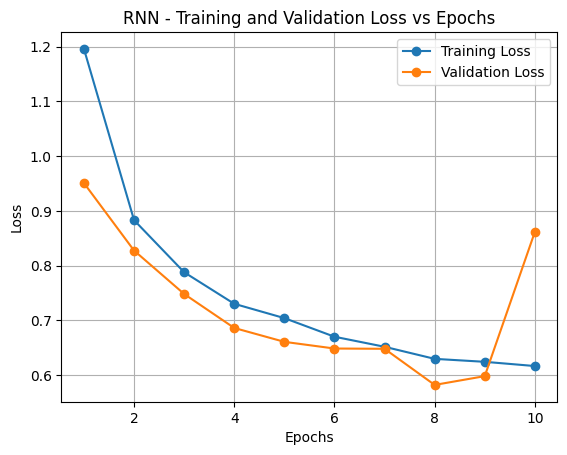

In [ ]:
import matplotlib.pyplot as plt

# === RNN ===
epochs = range(1, len(rnn_history.history['accuracy']) + 1)
rnn_train_error = [1 - x for x in rnn_history.history['accuracy']]
rnn_val_error = [1 - x for x in rnn_history.history['val_accuracy']]

# 1. Training Error vs Epochs
plt.figure()
plt.plot(epochs, rnn_train_error, marker='o')
plt.title("RNN - Training Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.grid(True)
plt.show()

# 2. Training + Validation Error vs Epochs
plt.figure()
plt.plot(epochs, rnn_train_error, marker='o', label="Training Error")
plt.plot(epochs, rnn_val_error, marker='o', label="Validation Error")
plt.title("RNN - Training and Validation Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# 3. Training + Validation Loss vs Epochs
plt.figure()
plt.plot(epochs, rnn_history.history['loss'], marker='o', label="Training Loss")
plt.plot(epochs, rnn_history.history['val_loss'], marker='o', label="Validation Loss")
plt.title("RNN - Training and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **2-layer LSTM: Model Definition**

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

# 2-layer stacked LSTM model for sequence-to-sequence translation
def stacked_lstm_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3

    # Input layer
    input_seq = Input(shape=input_shape[1:])

    # Stacked LSTM layers
    lstm_1 = LSTM(128, return_sequences=True)(input_seq)
    lstm_2 = LSTM(128, return_sequences=True)(lstm_1)

    # TimeDistributed output layer
    logits = TimeDistributed(Dense(french_vocab_size))(lstm_2)
    output = Activation('softmax')(logits)

    # Create and compile model
    model = Model(inputs=input_seq, outputs=output)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

(21, 1)


# **2-layer LSTM: Training**

In [ ]:
# Train the neural network
stacked_lstm = stacked_lstm_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

# Display the model architecture
stacked_lstm.summary()

# Train the model
lstm_history = stacked_lstm.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 21, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 21, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 21, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 21, 345)             │          44,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 345)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,649 (947.85 KB)

 Trainable params: 242,649 (947.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.5119 - loss: 2.1479 - val_accuracy: 0.5400 - val_loss: 1.8387
Epoch 2/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - accuracy: 0.5390 - loss: 1.8357 - val_accuracy: 0.5439 - val_loss: 1.8170
Epoch 3/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.5429 - loss: 1.8134 - val_accuracy: 0.5427 - val_loss: 1.8079
Epoch 4/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - accuracy: 0.5429 - loss: 1.8070 - val_accuracy: 0.5455 - val_loss: 1.7950
Epoch 5/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.5440 - loss: 1.7994 - val_accuracy: 0.5467 - val_loss: 1.7896
Epoch 6/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5452 - loss: 1.7934 - val_accuracy: 0.5380 - val_loss: 1.8306
Epoch 7/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.5453 - loss: 1.7916 - val_accuracy: 0.5460 - val_loss: 1.7867
Epoch 8/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.5455 - loss: 1

# **Stacked 2-layer LSTM: English to French Translation**

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences as pad

# reverse tokenizer for English and French
reverse_french_tokenizer = {index: word for word, index in french_tokenizer.word_index.items()}
reverse_french_tokenizer[0] = '<PAD>'

reverse_english_tokenizer = {index: word for word, index in english_tokenizer.word_index.items()}
reverse_english_tokenizer[0] = '<PAD>'

# 10 english input
sample_inputs = preproc_english_sentences[:10]

# Pad and reshape inputs, same as training
sample_inputs = pad(sample_inputs, max_french_sequence_length)
sample_inputs = sample_inputs.reshape((-1, max_french_sequence_length, 1))

# predict French translations using the stacked 2-layer LSTM model
predictions = stacked_lstm.predict(sample_inputs)
predicted_token_ids = predictions.argmax(axis=-1)

# helper function to decode token sequences into readable sentences
def decode_tokens(token_ids, tokenizer_dict):
    return ' '.join([tokenizer_dict.get(token, '') for token in token_ids if token != 0])

# predict 10 english to french translations
for i in range(10):
    original_eng_tokens = preproc_english_sentences[i]
    english_sentence = decode_tokens(original_eng_tokens, reverse_english_tokenizer)
    french_sentence = decode_tokens(predicted_token_ids[i], reverse_french_tokenizer)

    print(f"English {i+1}: {english_sentence}")
    print(f"French {i+1}: {french_sentence}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
English 1: new jersey is sometimes quiet during autumn and it is snowy in april
French 1: la est est est en en l' et il est il en en en

English 2: the united states is usually chilly during july and it is usually freezing in november
French 2: la est est est en en en mois et il est il en en

English 3: california is usually quiet during march and it is usually hot in june
French 3: la est est est en en mais il est est en en en

English 4: the united states is sometimes mild during june and it is cold in september
French 4: la est est est en en en mois et il est il est en

English 5: your least liked fruit is the grape but my least liked is the apple
French 5: la est est est en en mais mais moins aimé est la

English 6: his favorite fruit is the orange but my favorite is the grape
French 6: la est est est en en mais leur favori est la

English 7: paris is relaxing during december but it is usually chilly in july
French 7: la est est est en en et i

2-layer LSTM: Graph

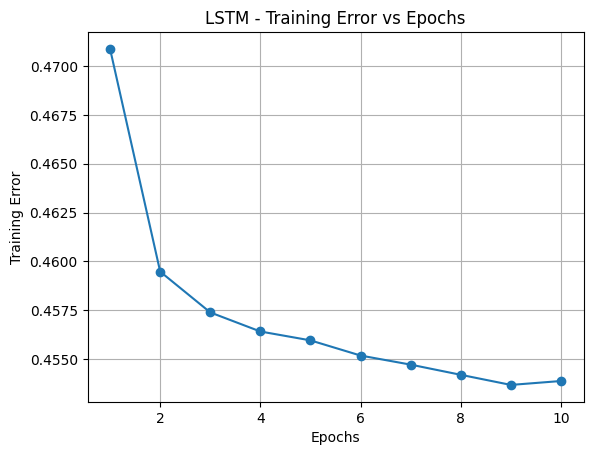

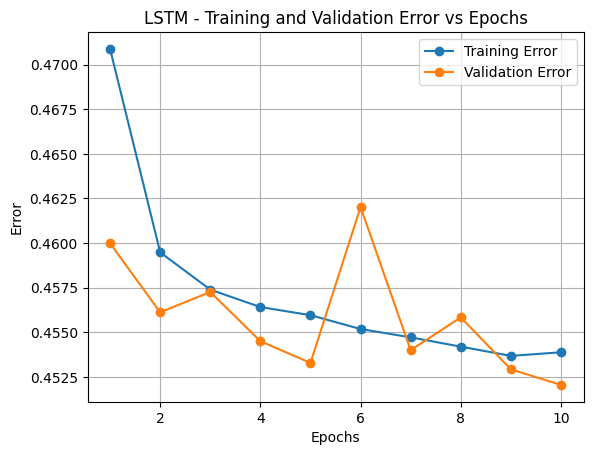

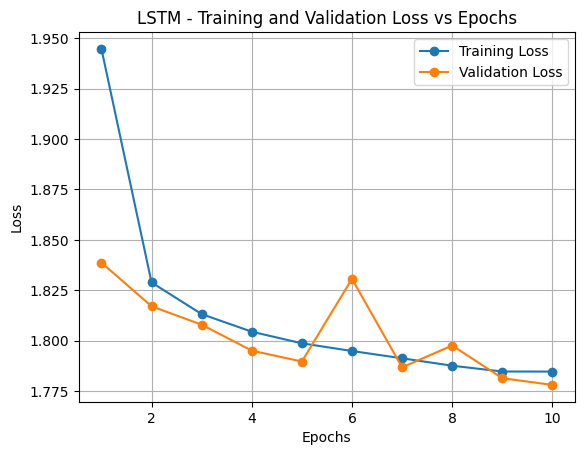

In [ ]:
# === LSTM ===
epochs = range(1, len(lstm_history.history['accuracy']) + 1)
lstm_train_error = [1 - x for x in lstm_history.history['accuracy']]
lstm_val_error = [1 - x for x in lstm_history.history['val_accuracy']]

# 1. Training Error vs Epochs
plt.figure()
plt.plot(epochs, lstm_train_error, marker='o')
plt.title("LSTM - Training Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.grid(True)
plt.show()

# 2. Training + Validation Error vs Epochs
plt.figure()
plt.plot(epochs, lstm_train_error, marker='o', label="Training Error")
plt.plot(epochs, lstm_val_error, marker='o', label="Validation Error")
plt.title("LSTM - Training and Validation Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# 3. Training + Validation Loss vs Epochs
plt.figure()
plt.plot(epochs, lstm_history.history['loss'], marker='o', label="Training Loss")
plt.plot(epochs, lstm_history.history['val_loss'], marker='o', label="Validation Loss")
plt.title("LSTM - Training and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## **2-layer GRU: Model Definition**

In [ ]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, TimeDistributed, Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

# 2-layer stacked GRU model for sequence-to-sequence translation
def stacked_gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3

    # Input layer
    input_seq = Input(shape=input_shape[1:])

    # Stacked GRU layers
    gru_1 = GRU(128, return_sequences=True)(input_seq)
    gru_2 = GRU(128, return_sequences=True)(gru_1)

    # TimeDistributed output layer
    logits = TimeDistributed(Dense(french_vocab_size))(gru_2)
    output = Activation('softmax')(logits)

    # Create and compile model
    model = Model(inputs=input_seq, outputs=output)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

(21, 1)


# **2-layer GRU: Training**

In [ ]:
# Train the neural network
stacked_gru = stacked_gru_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

# Display the model architecture
stacked_gru.summary()

# Train the model
gru_history = stacked_gru.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 21, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 21, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 21, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 21, 345)             │          44,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 345)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,881 (757.35 KB)

 Trainable params: 193,881 (757.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.5141 - loss: 2.1123 - val_accuracy: 0.5408 - val_loss: 1.8432
Epoch 2/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.5399 - loss: 1.8371 - val_accuracy: 0.5437 - val_loss: 1.8116
Epoch 3/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - accuracy: 0.5417 - loss: 1.8214 - val_accuracy: 0.5423 - val_loss: 1.8172
Epoch 4/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.5420 - loss: 1.8143 - val_accuracy: 0.5457 - val_loss: 1.7989
Epoch 5/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.5418 - loss: 1.8126 - val_accuracy: 0.5449 - val_loss: 1.7994
Epoch 6/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.5434 - loss: 1.8054 - val_accuracy: 0.5431 - val_loss: 1.8034
Epoch 7/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.5436 - loss: 1.8013 - val_accuracy: 0.5454 - val_loss: 1.7953
Epoch 8/10
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - accuracy: 0.5449 - loss: 1

# **Stacked 2-layer GRU: English to French Translation**

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences as pad

# reverse tokenizer for English and French
reverse_french_tokenizer = {index: word for word, index in french_tokenizer.word_index.items()}
reverse_french_tokenizer[0] = '<PAD>'

reverse_english_tokenizer = {index: word for word, index in english_tokenizer.word_index.items()}
reverse_english_tokenizer[0] = '<PAD>'

# 10 english input
sample_inputs = preproc_english_sentences[:10]

# Pad and reshape inputs, same as training
sample_inputs = pad(sample_inputs, max_french_sequence_length)
sample_inputs = sample_inputs.reshape((-1, max_french_sequence_length, 1))

# predict French translations using the stacked 2-layer GRU model
predictions = stacked_gru.predict(sample_inputs)
predicted_token_ids = predictions.argmax(axis=-1)

# helper function to decode token sequences into readable sentences
def decode_tokens(token_ids, tokenizer_dict):
    return ' '.join([tokenizer_dict.get(token, '') for token in token_ids if token != 0])

# predict 10 english to french translations
for i in range(10):
    original_eng_tokens = preproc_english_sentences[i]
    english_sentence = decode_tokens(original_eng_tokens, reverse_english_tokenizer)
    french_sentence = decode_tokens(predicted_token_ids[i], reverse_french_tokenizer)

    print(f"English {i+1}: {english_sentence}")
    print(f"French {i+1}: {french_sentence}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
English 1: new jersey is sometimes quiet during autumn and it is snowy in april
French 1: la est est est les en et et il est il en en en en

English 2: the united states is usually chilly during july and it is usually freezing in november
French 2: la est est est les en en mois et il est il en en

English 3: california is usually quiet during march and it is usually hot in june
French 3: la est est est les en et il est parfois en en en

English 4: the united states is sometimes mild during june and it is cold in september
French 4: la est est est les en en mois et il est il en en

English 5: your least liked fruit is the grape but my least liked is the apple
French 5: la est est est les en la mais mais moins aimé est la

English 6: his favorite fruit is the orange but my favorite is the grape
French 6: la est est est les en mais favori est la

English 7: paris is relaxing during december but it is usually chilly in july
French 7: la est est est le

2 layer GRU: Graph Plotting

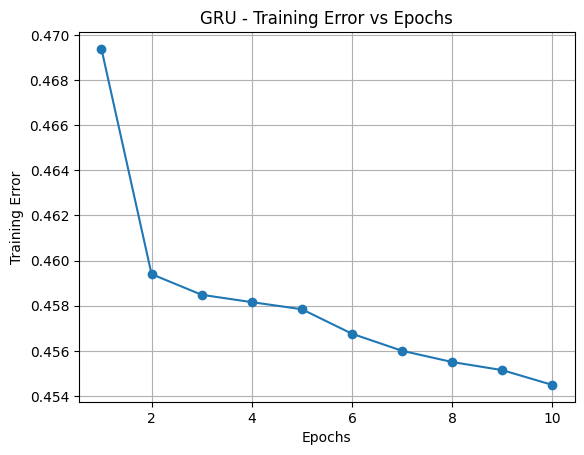

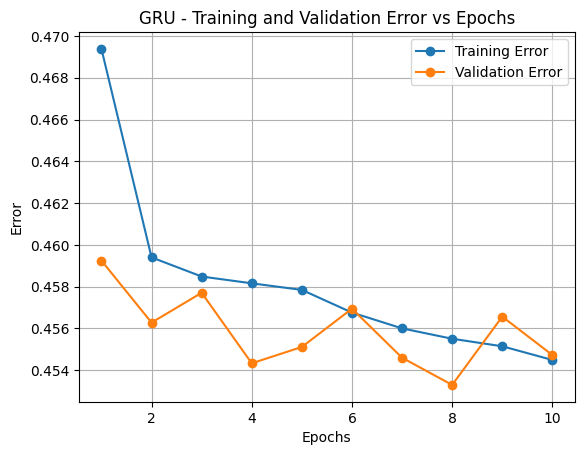

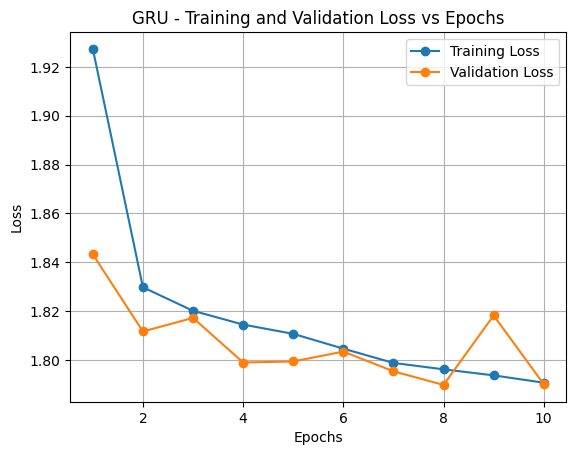

In [ ]:
# === GRU ===
epochs = range(1, len(gru_history.history['accuracy']) + 1)
gru_train_error = [1 - x for x in gru_history.history['accuracy']]
gru_val_error = [1 - x for x in gru_history.history['val_accuracy']]

# 1. Training Error vs Epochs
plt.figure()
plt.plot(epochs, gru_train_error, marker='o')
plt.title("GRU - Training Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.grid(True)
plt.show()

# 2. Training + Validation Error vs Epochs
plt.figure()
plt.plot(epochs, gru_train_error, marker='o', label="Training Error")
plt.plot(epochs, gru_val_error, marker='o', label="Validation Error")
plt.title("GRU - Training and Validation Error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# 3. Training + Validation Loss vs Epochs
plt.figure()
plt.plot(epochs, gru_history.history['loss'], marker='o', label="Training Loss")
plt.plot(epochs, gru_history.history['val_loss'], marker='o', label="Validation Loss")
plt.title("GRU - Training and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Comparison of English to French Translation for all Model

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences as pad

# Reverse tokenizers for decoding
reverse_french_tokenizer = {index: word for word, index in french_tokenizer.word_index.items()}
reverse_french_tokenizer[0] = '<PAD>'
reverse_english_tokenizer = {index: word for word, index in english_tokenizer.word_index.items()}
reverse_english_tokenizer[0] = '<PAD>'

# Select and pad the same 10 English sentences
sample_inputs = preproc_english_sentences[:10]

# Pad and reshape inputs, same as training
sample_inputs = pad(sample_inputs, max_french_sequence_length)
sample_inputs = sample_inputs.reshape((-1, max_french_sequence_length, 1))

# Predict using all three models
rnn_preds = stacked_rnn.predict(sample_inputs)
lstm_preds = stacked_lstm.predict(sample_inputs)
gru_preds = stacked_gru.predict(sample_inputs)

# Convert predictions to token IDs
rnn_tokens = rnn_preds.argmax(axis=-1)
lstm_tokens = lstm_preds.argmax(axis=-1)
gru_tokens = gru_preds.argmax(axis=-1)

# Helper to decode tokens into sentence
def decode_tokens(token_ids, tokenizer_dict):
    return ' '.join([tokenizer_dict.get(token, '') for token in token_ids if token != 0])

# Display side-by-side comparison
print("Comparison of Translations from Stacked RNN, LSTM, and GRU\n")

for i in range(10):
    english_sentence = decode_tokens(preproc_english_sentences[i], reverse_english_tokenizer)
    rnn_translation = decode_tokens(rnn_tokens[i], reverse_french_tokenizer)
    lstm_translation = decode_tokens(lstm_tokens[i], reverse_french_tokenizer)
    gru_translation = decode_tokens(gru_tokens[i], reverse_french_tokenizer)

    print(f"English {i+1}: {english_sentence}")
    print(f"  RNN  ➜ {rnn_translation}")
    print(f"  LSTM ➜ {lstm_translation}")
    print(f"  GRU  ➜ {gru_translation}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
🔁 Comparison of Translations from Stacked RNN, LSTM, and GRU

English 1: new jersey is sometimes quiet during autumn and it is snowy in april
  RNN  ➜ bien new raisin new new new new unis est parfois chaud en mois et il est et il en
  LSTM ➜ la est est est en en l' et il est il en en en
  GRU  ➜ la est est est les en et et il est il en en en en

English 2: the united states is usually chilly during july and it is usually freezing in november
  RNN  ➜ bien new raisin new new new new new unis est jamais doux en juillet et il est généralement beau en novembre
  LSTM ➜ la est est est en en en mois et il est il en en
  GRU  ➜ la est est est les en en mois et il est il en en

English 3: california is usually quiet during march and it is usually hot in june
  RNN  ➜ bien new raisin new new new new est généralement habituellement en mars et il est généralement calme en juin
  LSTM